# KBS Assignment 1  
## Nairobi Securities Exchange Stock Price Prediction (2007–2012)

### Objective
To build and evaluate regression models that predict numerical stock values
using historical data from the Nairobi Securities Exchange (NSE).

### Dataset
- Source: NSE All Stocks Prices (2007–2012)
- Format: Daily trading records per stock

### Task
- Select one or more stocks(picked SCOM)
- Engineer features from historical prices
- Train regression models
- Evaluate performance of models using MSE, RMSE, R²
- Produce residual and error plots


Imports that will be used

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Loading and combining the data from 2007 to 2012

In [60]:
def load_nse_data():
    """Load and combine all NSE CSV files"""
    
    data_folder = "../data/"
    years = list(range(2007, 2013))#upto 2012
    data_frames = []
    
    for year in years:
        file_path = os.path.join(data_folder, f"NSE_data_all_stocks_{year}.csv")
        if os.path.exists(file_path):
            df_year = pd.read_csv(file_path)
            df_year['Year'] = year
            data_frames.append(df_year)
            print(f"✓ {year}: {len(df_year)} records")
    
    nse_data = pd.concat(data_frames, ignore_index=True)
    print(f"\nCombined dataset shape: {nse_data.shape}")
    
    return nse_data


Inspecting the datasets

In [61]:
nse_data = load_nse_data()

print("Columns:")
print(nse_data.columns)

print("\nMost common stocks:")
print(nse_data['CODE'].value_counts().head(10))

✓ 2007: 10608 records
✓ 2008: 10583 records
✓ 2009: 14386 records
✓ 2010: 14952 records
✓ 2011: 14931 records
✓ 2012: 16044 records

Combined dataset shape: (81504, 16)
Columns:
Index(['DATE', 'CODE', 'NAME', '12m Low', '12m High', 'Day Low', 'Day High',
       'Day Price', 'Previous', 'Change', 'Change%', 'Volume', 'Adjust',
       'Year', 'Date', 'Adjusted'],
      dtype='object')

Most common stocks:
CODE
HFCK    1501
KCB     1501
KEGN    1501
EVRD    1501
MSC     1501
NIC     1500
SCAN    1500
BBK     1500
CMC     1500
SASN    1500
Name: count, dtype: int64


In [62]:
def clean_numeric_column(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str).str.replace(',', '')
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df

Selecting the stock and clean numeric columns

In [63]:
stock_code = "SCOM" #Safaricom
stock_data = nse_data[nse_data['CODE'] == stock_code].copy()

stock_data['DATE'] = pd.to_datetime(stock_data['DATE'])
stock_data = stock_data.sort_values('DATE')

print(f"Trading days: {len(stock_data)}")
print(f"Date range: {stock_data['DATE'].min().date()} to {stock_data['DATE'].max().date()}")

stock_data['Day Price'].describe()

Trading days: 1146
Date range: 2009-01-02 to 2012-12-31


count     1146
unique      91
top        3.9
freq        46
Name: Day Price, dtype: object

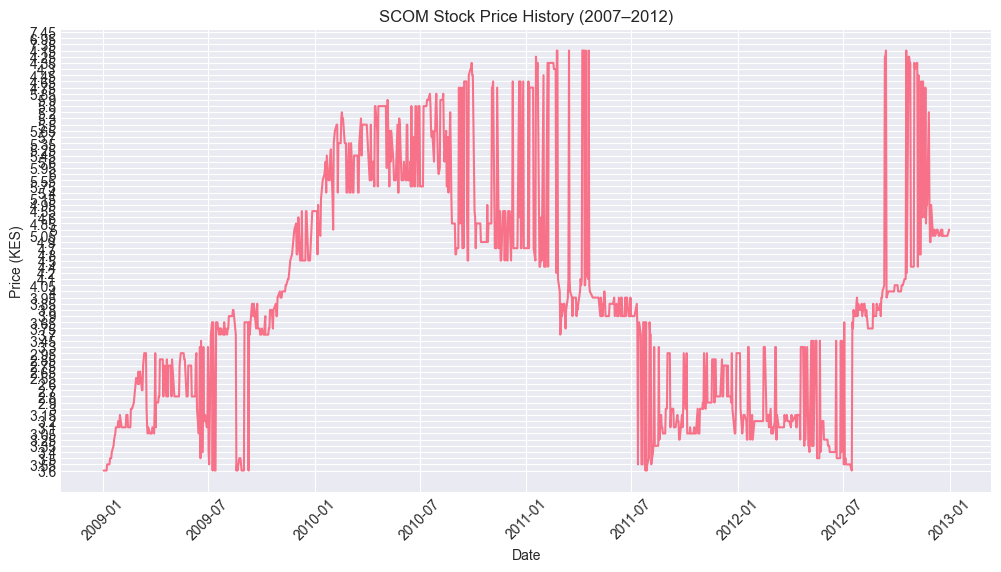

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['DATE'], stock_data['Day Price'])
plt.xlabel('Date')
plt.ylabel('Price (KES)')
plt.title(f'{stock_code} Stock Price History (2007–2012)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Converting numeric columns from strings

In [65]:
numeric_cols = [
    'Day Price',
    'Day High',
    'Day Low',
    'Previous',
    'Volume',
    'Change',
    'Change%'
]

for col in numeric_cols:
    if col in stock_data.columns:
        stock_data[col] = (
            stock_data[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace('%', '', regex=False)
            .replace('-', np.nan)
        )
        stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

# Confirm conversion
stock_data[numeric_cols].dtypes


Day Price    float64
Day High     float64
Day Low      float64
Previous     float64
Volume         int64
Change       float64
Change%      float64
dtype: object

In [66]:
stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

stock_data['Change'] = stock_data['Change'].fillna(0)
stock_data['Change%'] = stock_data['Change%'].fillna(0)

target_col = 'Day Price'
print(f"Trading days: {len(stock_data)}")
print(f"Date range: {stock_data['DATE'].min().date()} to {stock_data['DATE'].max().date()}")

Trading days: 1146
Date range: 2009-01-02 to 2012-12-31


Reduced lags and rolling windows to prevent zero rows

In [67]:
# Reduce lag features
num_lags = 2 
for lag in range(1, num_lags + 1):
    stock_data[f'Price_lag_{lag}'] = stock_data[target_col].shift(lag)

# Reduce moving averages
stock_data['Price_MA_2'] = stock_data[target_col].rolling(2).mean().shift(1)
stock_data['Price_MA_5'] = stock_data[target_col].rolling(5).mean().shift(1)

# Daily range and volume
stock_data['Daily_Range'] = (stock_data['Day High'] - stock_data['Day Low']) / stock_data[target_col]
stock_data['Daily_Range_lag1'] = stock_data['Daily_Range'].shift(1)

stock_data['Volume_lag1'] = stock_data['Volume'].shift(1)
stock_data['Volume_MA_2'] = stock_data['Volume'].rolling(2).mean().shift(1)

# Other features
stock_data['Change_lag1'] = stock_data['Change'].shift(1)
stock_data['Change%_lag1'] = stock_data['Change%'].shift(1)
stock_data['Previous_lag1'] = stock_data['Previous'].shift(1)

# Drop rows with NaNs in features only
feature_cols = [f'Price_lag_{i}' for i in range(1, num_lags+1)] + [
    'Price_MA_2','Price_MA_5',
    'Daily_Range_lag1','Volume_lag1','Volume_MA_2',
    'Change_lag1','Change%_lag1','Previous_lag1'
]

stock_data_clean = stock_data.dropna(subset=feature_cols + [target_col])
print("Shape after cleaning:", stock_data_clean.shape)


Shape after cleaning: (1141, 27)


Train-Test Split

In [68]:
X = stock_data_clean[feature_cols]
y = stock_data_clean[target_col]

split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (912, 10)
Test set: (229, 10)


Initialize and Train Models

In [69]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

Predictions

In [70]:
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

Evaluating Models

In [71]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}\n")
    return mse, rmse, mae, r2

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

--- Linear Regression Evaluation ---
MSE: 1.3256
RMSE: 1.1514
MAE: 0.1558
R²: 0.0767

--- Random Forest Evaluation ---
MSE: 0.3159
RMSE: 0.5621
MAE: 0.2754
R²: 0.7800



(0.31590892167030415,
 np.float64(0.5620577565253452),
 0.2753526200873347,
 0.7799626262836321)

Comparing predictions with the actual prices

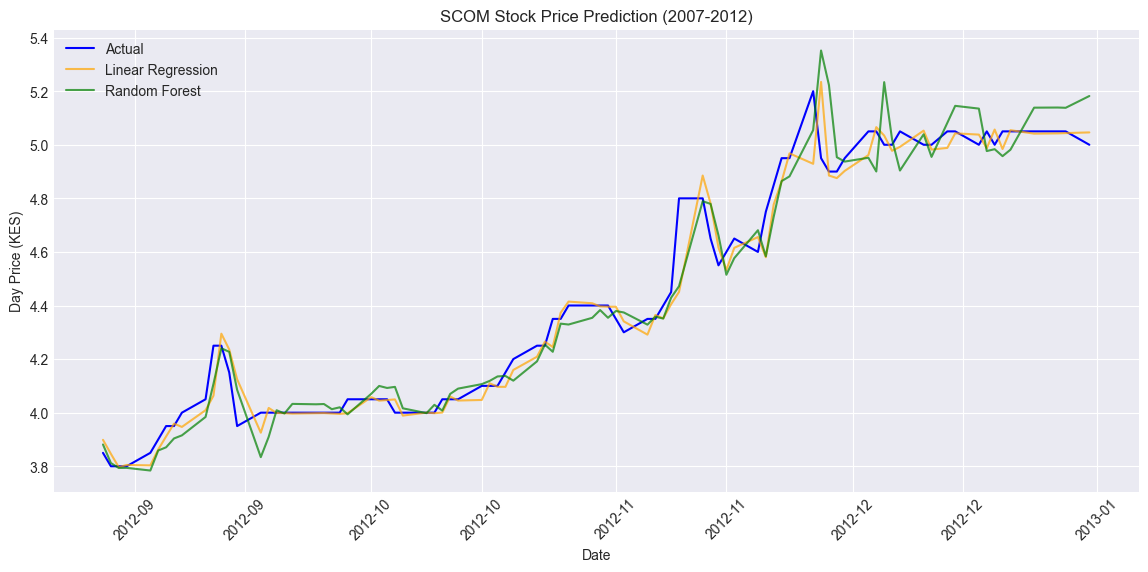

In [72]:
plt.figure(figsize=(14,6))
plt.plot(stock_data_clean['DATE'].iloc[split_index:], y_test, label='Actual', color='blue')
plt.plot(stock_data_clean['DATE'].iloc[split_index:], y_pred_lr, label='Linear Regression', color='orange', alpha=0.7)
plt.plot(stock_data_clean['DATE'].iloc[split_index:], y_pred_rf, label='Random Forest', color='green', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Day Price (KES)")
plt.title(f"{stock_code} Stock Price Prediction (2007-2012)")
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

Residual Plots

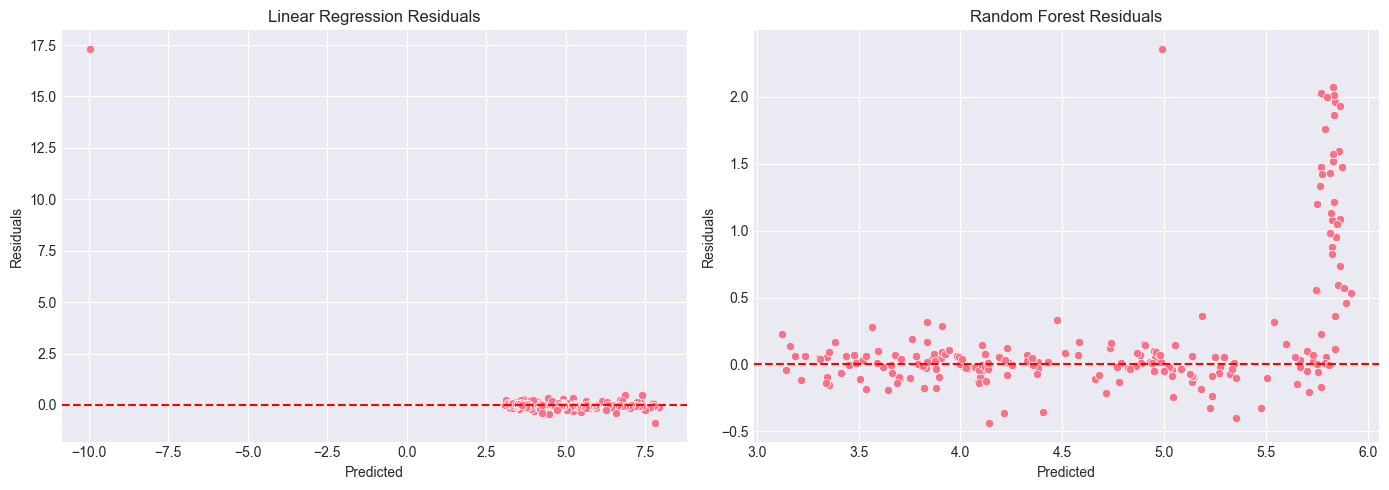

In [73]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
residuals_lr = y_test - y_pred_lr
sns.scatterplot(x=y_pred_lr, y=residuals_lr)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Linear Regression Residuals")

plt.subplot(1,2,2)
residuals_rf = y_test - y_pred_rf
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forest Residuals")

plt.tight_layout()
plt.show()

Prediction Error Over Time

Prediction error over time

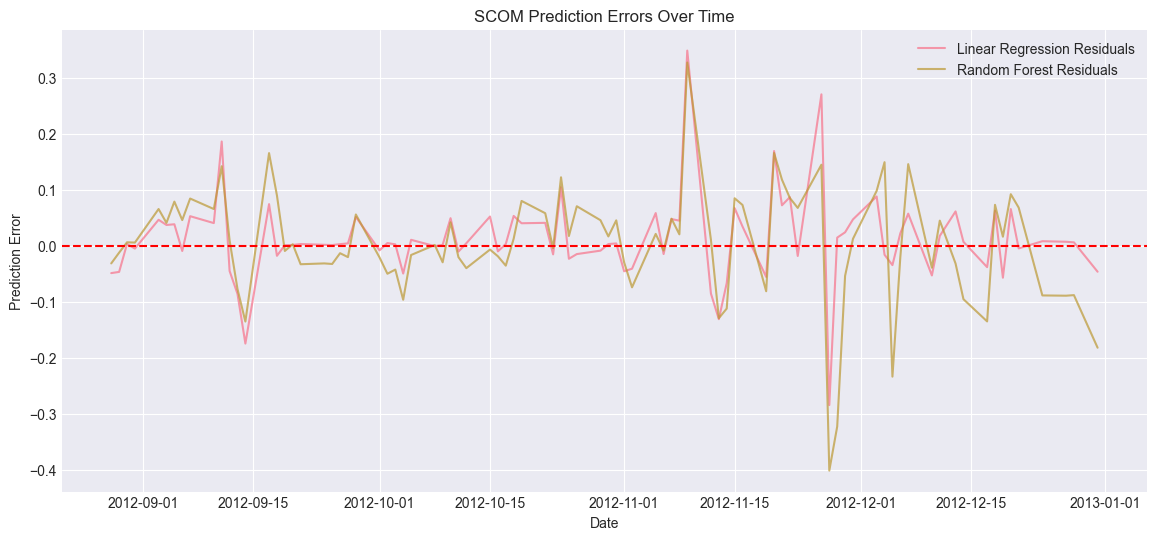

In [78]:
plt.figure(figsize=(14,6))
plt.plot(stock_data_clean['DATE'].iloc[split_index:], residuals_lr, label='Linear Regression Residuals', alpha=0.7)
plt.plot(stock_data_clean['DATE'].iloc[split_index:], residuals_rf, label='Random Forest Residuals', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.title(f"{stock_code} Prediction Errors Over Time")
plt.legend()
plt.show()

Summary of Model Performance

Summary of model performance

In [77]:
metrics = {}

metrics['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression")
metrics['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")

metrics_df = pd.DataFrame(metrics, index=['MSE', 'RMSE', 'MAE', 'R²']).T
metrics_df = metrics_df.round(4)

print("### Model Performance Summary")
metrics_df

--- Linear Regression Evaluation ---
MSE: 1.3256
RMSE: 1.1514
MAE: 0.1558
R²: 0.0767

--- Random Forest Evaluation ---
MSE: 0.3159
RMSE: 0.5621
MAE: 0.2754
R²: 0.7800

### Model Performance Summary


,MSE,RMSE,MAE,R²
Linear Regression,1.3256,1.1514,0.1558,0.0767
Random Forest,0.3159,0.5621,0.2754,0.7800
